## Emir TAS - 21103718   
## Kishanthan KINGSTON - 21209700



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from scipy.stats import ttest_rel
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
# GridWorldEnvironment class
class GridWorldEnvironment:
    def __init__(self, grid_size=(5, 5), obstacles=[]):
        self.grid_size = grid_size
        self.state_space = np.prod(grid_size)
        self.action_space = 4  # Four possible actions: Up, Down, Left, Right
        self.state = None
        self.obstacles = obstacles

    def reset(self):
        # Randomly select an initial state that is not an obstacle
        self.state = np.random.randint(0, self.state_space)
        while self.state in self.obstacles:
            # We keep selecting until a valid initial state is found
            self.state = np.random.randint(0, self.state_space)
        return self.state


    def step(self, action):
        if self.state is None:
            raise Exception("You must call reset() before step()")

        # Define transitions for each action (move in the grid)
        next_state = self.state

        # Add your code here
        if action == 0:  # Up
            next_state = self.state - self.grid_size[1]
        elif action == 1:  # Down
            next_state = self.state + self.grid_size[1]
        elif action == 2:  # Left
            next_state = self.state - 1
        elif action == 3:  # Right
            next_state = self.state + 1
        else:
            raise ValueError("Invalid action")


        # Update the state if the next state is not an obstacle
        if next_state not in self.obstacles:
            self.state = next_state
        else:
            return self.state, -1, False  # Negative reward for hitting an obstacle

        # Define the reward function (e.g., reaching a goal state)
        done = (self.state == self.state_space - 1)  # Goal state
        reward = 1 if done else 0

        return self.state, reward, done

In [ ]:
# Generate expert demonstrations
def generate_expert_demonstrations(env, num_demos):
    expert_demonstrations = []

    for _ in range(num_demos):
        state = env.reset()
        trajectory = []

        while state != env.state_space - 1:  # Continue until reaching the goal state
            # Define a policy to reach the goal state while avoiding obstacles
            action = simple_policy(env, state)
            next_state, reward, done = env.step(action)
            trajectory.append((state, action))
            state = next_state


        expert_demonstrations.append(trajectory)

    return expert_demonstrations

def simple_policy(env, state):
    # A simple policy that avoids obstacles and follows a right-down strategy.
    if state % env.grid_size[1] < env.grid_size[1] - 1:
        action = 3  # Move right
    else:
        action = 1  # Move down

    return action

def expert_policy(state):
    grid_size = (5, 5)  # Define the grid size here
    state_space = np.prod(grid_size)
    goal_state = state_space - 1

    # Calculate the row and column of the current state
    row = state // grid_size[1]
    col = state % grid_size[1]

    # Calculate the row and column of the goal state
    goal_row = goal_state // grid_size[1]
    goal_col = goal_state % grid_size[1]

    # If the current row is less than the goal row, move down
    if row < goal_row:
        return 1  # Down

    # If the current column is less than the goal column, move right
    elif col < goal_col:
        return 3  # Right

    # If the current state is the goal state, stay in place
    elif state == goal_state:
        return 0  # Up (or any other action)

    # If none of the above conditions are met, move up
    else:
        return 0  # Up

# Create the grid world environment
env = GridWorldEnvironment()

# Generate expert demonstrations
num_demos = 25  # You can adjust the number of demonstrations
expert_demonstrations = generate_expert_demonstrations(env, num_demos)

# Print the expert demonstrations
for idx, demo in enumerate(expert_demonstrations):
    print(f"Expert Demonstration {idx + 1}: {demo}")

Expert Demonstration 1: [(6, 3), (7, 3), (8, 3), (9, 1), (14, 1), (19, 1)]
Expert Demonstration 2: [(21, 3), (22, 3), (23, 3)]
Expert Demonstration 3: [(12, 3), (13, 3), (14, 1), (19, 1)]
Expert Demonstration 4: [(5, 3), (6, 3), (7, 3), (8, 3), (9, 1), (14, 1), (19, 1)]
Expert Demonstration 5: [(6, 3), (7, 3), (8, 3), (9, 1), (14, 1), (19, 1)]
Expert Demonstration 6: [(4, 1), (9, 1), (14, 1), (19, 1)]
Expert Demonstration 7: [(12, 3), (13, 3), (14, 1), (19, 1)]
Expert Demonstration 8: [(15, 3), (16, 3), (17, 3), (18, 3), (19, 1)]
Expert Demonstration 9: [(5, 3), (6, 3), (7, 3), (8, 3), (9, 1), (14, 1), (19, 1)]
Expert Demonstration 10: [(8, 3), (9, 1), (14, 1), (19, 1)]
Expert Demonstration 11: [(10, 3), (11, 3), (12, 3), (13, 3), (14, 1), (19, 1)]
Expert Demonstration 12: [(1, 3), (2, 3), (3, 3), (4, 1), (9, 1), (14, 1), (19, 1)]
Expert Demonstration 13: [(1, 3), (2, 3), (3, 3), (4, 1), (9, 1), (14, 1), (19, 1)]
Expert Demonstration 14: [(15, 3), (16, 3), (17, 3), (18, 3), (19, 1)]
Ex

In [ ]:
# Define the Behavioral Cloning Model
class BehavioralCloningModel(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(BehavioralCloningModel, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def trainBC(self, states, actions, epochs=100, batch_size=32):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        loss_fn = nn.CrossEntropyLoss()

        states = torch.tensor(states, dtype=torch.float32)
        print('states', states)
        actions = torch.tensor(actions, dtype=torch.int64)

        dataset = torch.utils.data.TensorDataset(states, actions)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

        accuracy_values = []
        loss_values = []  # Initialize loss_values to track loss values

        for epoch in range(epochs):
            total_loss = 0.0
            correct_predictions = 0

            for batch_states, batch_actions in dataloader:
                optimizer.zero_grad()
                predicted_actions = modelBC(batch_states)
                loss = loss_fn(predicted_actions, batch_actions)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

                # Calculate the number of correct predictions in the current batch
                correct_predictions += (predicted_actions.argmax(dim=1) == batch_actions).sum().item()

            # Calculate accuracy for the current epoch and store it
            # Add your code here
            accuracy = correct_predictions / len(dataset)
            accuracy_values.append(accuracy)

            # Append the average loss for the current epoch to loss_values
            loss_values.append(total_loss / len(dataloader))

            #print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss_values[-1]:.4f}, Accuracy: {accuracy * 100:.2f}%')

        # Calculate standard deviation for loss and accuracy
        loss_std = np.std(loss_values)
        accuracy_std = np.std(accuracy_values)

        return loss_values, accuracy_values, loss_std, accuracy_std # Return loss and accuracy values


class DaggerModel(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DaggerModel, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def trainDA(self, states, actions, expert_policy, epochs=100, batch_size=32):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        loss_fn = nn.CrossEntropyLoss()

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64)

        dataset = torch.utils.data.TensorDataset(states, actions)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

        accuracy_values = []
        loss_values = []

        for epoch in range(epochs):
            total_loss = 0.0
            correct_predictions = 0

            for batch_states, batch_actions in dataloader:
                optimizer.zero_grad()
                predicted_actions = self(batch_states)
                loss = loss_fn(predicted_actions, batch_actions)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

                correct_predictions += (predicted_actions.argmax(dim=1) == batch_actions).sum().item()

            # DAgger: after each epoch, use the current model to produce actions, and ask the expert to label these actions
            new_actions = []
            with torch.no_grad():
                for state in states:
                    action = self(state).argmax().item()
                    new_action = expert_policy(state.numpy())
                    new_actions.append(new_action)
            actions = torch.tensor(new_actions, dtype=torch.int64)

            accuracy = correct_predictions / len(states)
            accuracy_values.append(accuracy)

            loss_values.append(total_loss / len(dataloader))

            #print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss_values[-1]:.4f}, Accuracy: {accuracy * 100:.2f}%')

        loss_std = np.std(loss_values)
        accuracy_std = np.std(accuracy_values)

        return loss_values, accuracy_values, loss_std, accuracy_std



# Extract states and actions from expert demonstrations
states = []
actions = []

for demonstration in expert_demonstrations:
    for state, action in demonstration:
        states.append([state])  # Wrap the state in a list to make it 2D (1x1)
        actions.append(action)

# Define state_dim and action_dim based on your data
state_dim = 1  # Assuming state is a scalar value
action_dim = max(actions) + 1  # Calculate action_dim based on the maximum action value

# Instantiate the model
modelBC = BehavioralCloningModel(state_dim, action_dim)
modelDAGGER = DaggerModel(state_dim, action_dim)

# Train the model with the expert demonstration data
loss_valuesBC, accuracy_valuesBC, loss_stdBC, accuracy_stdBC = modelBC.trainBC(states, actions, epochs=500, batch_size=32)
loss_valuesDAGGER, accuracy_valuesDAGGER, loss_stdDAGGER, accuracy_stdDAGGER = modelDAGGER.trainDA(states, actions, expert_policy, epochs=500, batch_size=32)#


states tensor([[ 6.],
        [ 7.],
        [ 8.],
        [ 9.],
        [14.],
        [19.],
        [21.],
        [22.],
        [23.],
        [12.],
        [13.],
        [14.],
        [19.],
        [ 5.],
        [ 6.],
        [ 7.],
        [ 8.],
        [ 9.],
        [14.],
        [19.],
        [ 6.],
        [ 7.],
        [ 8.],
        [ 9.],
        [14.],
        [19.],
        [ 4.],
        [ 9.],
        [14.],
        [19.],
        [12.],
        [13.],
        [14.],
        [19.],
        [15.],
        [16.],
        [17.],
        [18.],
        [19.],
        [ 5.],
        [ 6.],
        [ 7.],
        [ 8.],
        [ 9.],
        [14.],
        [19.],
        [ 8.],
        [ 9.],
        [14.],
        [19.],
        [10.],
        [11.],
        [12.],
        [13.],
        [14.],
        [19.],
        [ 1.],
        [ 2.],
        [ 3.],
        [ 4.],
        [ 9.],
        [14.],
        [19.],
        [ 1.],
        [ 2.],
        [ 3.],
   

In [ ]:
print(loss_valuesBC, accuracy_valuesBC, loss_stdBC, accuracy_stdBC)
print(loss_valuesDAGGER, accuracy_valuesDAGGER, loss_stdDAGGER, accuracy_stdDAGGER)

[1.4210255146026611, 1.0142898857593536, 0.8649403899908066, 0.8066837042570114, 0.7863610833883286, 0.7608674913644791, 0.7485529184341431, 0.7310004532337189, 0.7264786958694458, 0.7198121100664139, 0.7109395116567612, 0.696180909872055, 0.693718895316124, 0.7012714445590973, 0.6774695664644241, 0.6807577162981033, 0.6686844378709793, 0.6719574183225632, 0.6662660241127014, 0.6542773544788361, 0.6654659360647202, 0.6615963131189346, 0.6657712757587433, 0.6588979661464691, 0.6618297249078751, 0.643974095582962, 0.650221660733223, 0.6559415757656097, 0.6495396792888641, 0.6378651112318039, 0.6462787836790085, 0.6375599354505539, 0.631497859954834, 0.6383753567934036, 0.6324450671672821, 0.6235869377851486, 0.636589452624321, 0.62518510222435, 0.6535713523626328, 0.6299203783273697, 0.6406266391277313, 0.6380804926156998, 0.6305616348981857, 0.6208063513040543, 0.634665235877037, 0.6303069442510605, 0.6249303966760635, 0.624812975525856, 0.6223701983690262, 0.6223993748426437, 0.6232926

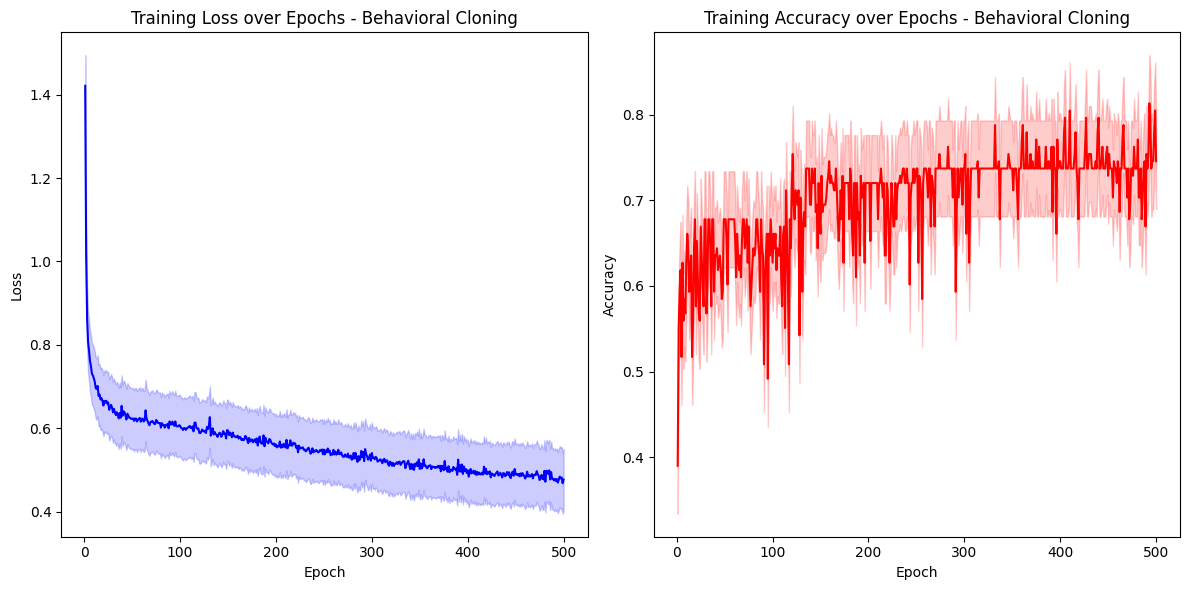

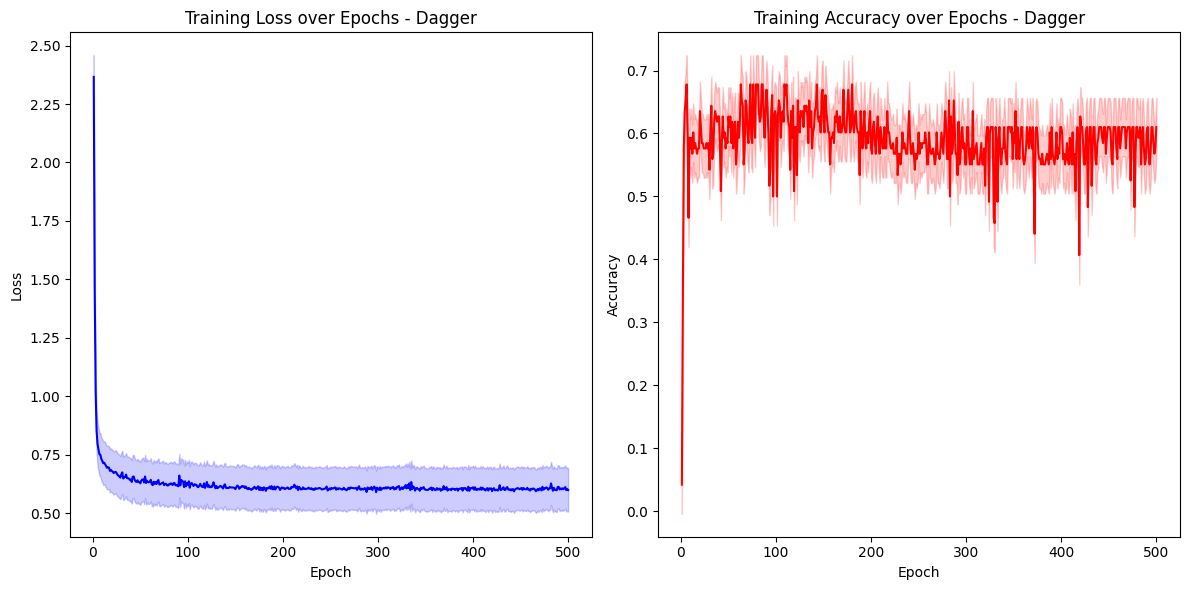

In [ ]:
epochs = 500
# Define lighter colors for the standard deviation lines
lighter_blue = "b"
lighter_red = "r"

# Plot Loss and Accuracy
# Add you code here
plt.figure(figsize=(12, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), loss_valuesBC, label="Loss", color="blue")
plt.fill_between(range(1, epochs + 1), np.array(loss_valuesBC) - loss_stdBC, np.array(loss_valuesBC) + loss_stdBC, color=lighter_blue, alpha=0.2)
plt.title("Training Loss over Epochs - Behavioral Cloning")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), accuracy_valuesBC, label="Accuracy", color="red")
plt.fill_between(range(1, epochs + 1), np.array(accuracy_valuesBC) - accuracy_stdBC, np.array(accuracy_valuesBC) + accuracy_stdBC, color=lighter_red, alpha=0.2)
plt.title("Training Accuracy over Epochs - Behavioral Cloning")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), loss_valuesDAGGER, label="Loss", color="blue")
plt.fill_between(range(1, epochs + 1), np.array(loss_valuesDAGGER) - loss_stdDAGGER, np.array(loss_valuesDAGGER) + loss_stdDAGGER, color=lighter_blue, alpha=0.2)
plt.title("Training Loss over Epochs - Dagger")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), accuracy_valuesDAGGER, label="Accuracy", color="red")
plt.fill_between(range(1, epochs + 1), np.array(accuracy_valuesDAGGER) - accuracy_stdDAGGER, np.array(accuracy_valuesDAGGER) + accuracy_stdDAGGER, color=lighter_red, alpha=0.2)
plt.title("Training Accuracy over Epochs - Dagger")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()




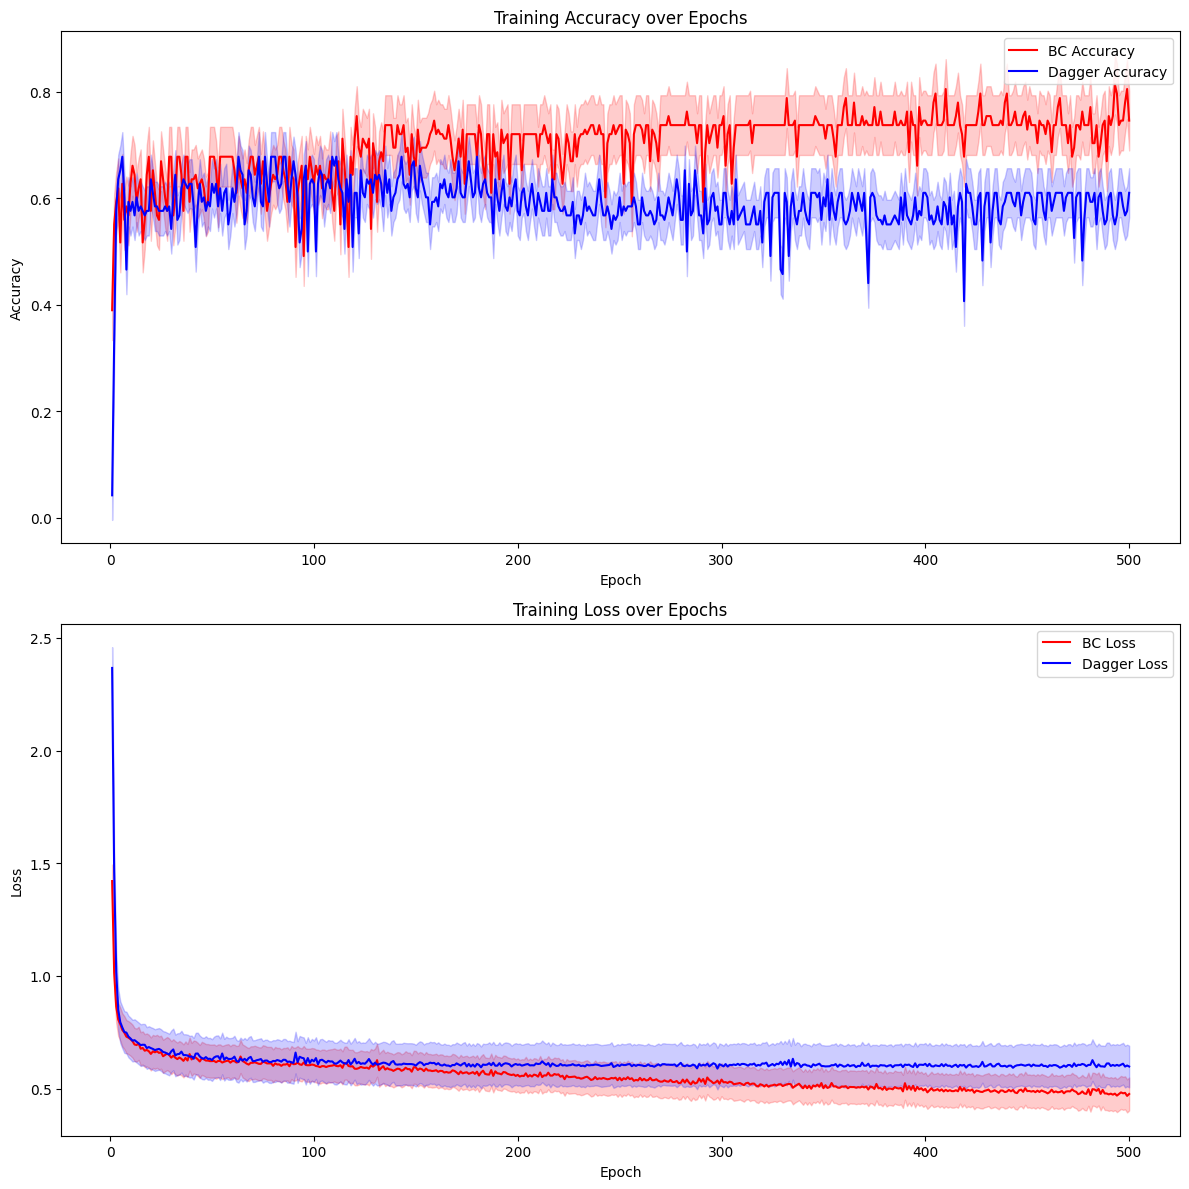

In [ ]:
epochs = 500
lighter_blue = "b"
lighter_red = "r"

# Plot Accuracy and Loss for Behavioral Cloning and Dagger
plt.figure(figsize=(12, 12))

# Subplot for Accuracy
plt.subplot(2, 1, 1)

# Behavioral Cloning Accuracy
plt.plot(range(1, epochs + 1), accuracy_valuesBC, label="BC Accuracy", color="red")
plt.fill_between(range(1, epochs + 1), np.array(accuracy_valuesBC) - accuracy_stdBC, np.array(accuracy_valuesBC) + accuracy_stdBC, color=lighter_red, alpha=0.2)

# Dagger Accuracy
plt.plot(range(1, epochs + 1), accuracy_valuesDAGGER, label="Dagger Accuracy", color="blue")
plt.fill_between(range(1, epochs + 1), np.array(accuracy_valuesDAGGER) - accuracy_stdDAGGER, np.array(accuracy_valuesDAGGER) + accuracy_stdDAGGER, color=lighter_blue, alpha=0.2)

plt.title("Training Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Subplot for Loss
plt.subplot(2, 1, 2)

# Behavioral Cloning Loss
plt.plot(range(1, epochs + 1), loss_valuesBC, label="BC Loss", color="red")
plt.fill_between(range(1, epochs + 1), np.array(loss_valuesBC) - loss_stdBC, np.array(loss_valuesBC) + loss_stdBC, color=lighter_red, alpha=0.2)

# Dagger Loss
plt.plot(range(1, epochs + 1), loss_valuesDAGGER, label="Dagger Loss", color="blue")
plt.fill_between(range(1, epochs + 1), np.array(loss_valuesDAGGER) - loss_stdDAGGER, np.array(loss_valuesDAGGER) + loss_stdDAGGER, color=lighter_blue, alpha=0.2)

plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Fonction pour évaluer le modèle
def evaluate_model(model, states, actions, threshold=0.5):
    model.eval()
    with torch.no_grad():
        # Prédiction des actions
        predicted_actions = model(torch.tensor(states, dtype=torch.float32))
        predicted_labels = predicted_actions.argmax(dim=1).numpy()

    # Utiliser les fonctions de sklearn pour calculer la précision, le rappel et le F1 score
    precision = precision_score(actions, predicted_labels, average='weighted')
    recall = recall_score(actions, predicted_labels, average='weighted')
    f1 = f1_score(actions, predicted_labels, average='weighted')

    return precision, recall, f1

mean_accuracy_BC = np.mean(accuracy_valuesBC)
mean_accuracy_DAGGER = np.mean(accuracy_valuesDAGGER)

# Évaluer le modèle Behavioral Cloning
precision_BC, recall_BC, f1_BC = evaluate_model(modelBC, states, actions)
print("Behavioral Cloning - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}".format(mean_accuracy_BC, precision_BC, recall_BC, f1_BC))

# Évaluer le modèle Dagger
precision_DAGGER, recall_DAGGER, f1_DAGGER = evaluate_model(modelDAGGER, states, actions)
print("Dagger - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}".format(mean_accuracy_DAGGER, precision_DAGGER, recall_DAGGER, f1_DAGGER))

Behavioral Cloning - Accuracy: 0.7012, Precision: 0.8298, Recall: 0.7373, F1 Score: 0.7206
Dagger - Accuracy: 0.5907, Precision: 0.7843, Recall: 0.6102, F1 Score: 0.5482


In [ ]:
# Combine all metrics into lists
metrics_BC = [mean_accuracy_BC, precision_BC, recall_BC, f1_BC]
metrics_DAGGER = [mean_accuracy_DAGGER, precision_DAGGER, recall_DAGGER, f1_DAGGER]

# Perform t-test for all metrics
t_value, p_value = ttest_rel(metrics_BC, metrics_DAGGER)

# Print the results
print("T-Test Results:")
print("t-value = {:.4f}, p-value = {:.4f}".format(t_value, p_value))

# Threshold
alpha = 0.05

if p_value < alpha:
    print("There is a significant difference between Behavioral Cloning and Dagger.")
else:
    print("There is no significant difference between Behavioral Cloning and Dagger.")


T-Test Results:
t-value = 4.3360, p-value = 0.0226
There is a significant difference between Behavioral Cloning and Dagger.
